# *Daphnia* DEB-TKTD-IBM example usage

The virtual environment defined in Project.toml and Manifest.toml has to be used. <br>
In some environments (e.g. VSCode), it will be loaded automatically. 
In others (e.g. HPC environment), it has to be loaded explicitly:

In [94]:
using Pkg; Pkg.activate(".")

  Activating project at `c:\Users\simon\UGent\WP4_2_ComMix2`


In case of doubt, activate the environment explicitly as done above.

Source code is stored in the `src` folder. <br>
All the function definitions and default parameters are loaded using `glob` and `include`:

In [2]:
using Glob
include.(glob("src/*.jl"));


(process:16724): GLib-GIO-WARNING **: 16:27:18.891: Unexpectedly, UWP app `KDEe.V.Okular_22.801.1132.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs


## Simulating individual life-history

As first example, we will simulate individual life-history, 
mimicking a life-table experiment.

Via `DefaultInput.jl`, default parameter sets are provided. <br>
We always need three sets of parameters:
- global_params: A dictionary containing global settings like maximum simulation time and initial conditions
- flea_params: A Vector of dictionaries containing individual-level parameters to simulate zooplankton (daphnids). One dictionary per species. 
- phyto_params: A Vector of dictionaries containing parameters of phytoplankton (food) species. When phytoplankton is not simulated dynamically (this part of the implementation is under development), most parameters are not relevant, but the phyto_params always have to be provided.

### Global paremeters

The default global parameters contain the following subsets, used to simulate corresponding 
trophic levels:

In [3]:
default_global |> typeof |> fieldnames

(:zooplankton, :phytoplankton, :two_trophic)

To simulate individual life-history, we copy the "lifetable" global parameters from the "zooplankton" subset.<br>
Using `copy` is necessary to avoid that changes to `glb` affect the default parameter set.

In [4]:
glb = copy(default_global.zooplankton[:lifetable]) # our global parameter set

OrderedDict{Symbol, Any} with 24 entries:
  :data_recording_interval => 1.0
  :record_flea_ind         => true
  :record_flea_pop         => false
  :record_phyto            => true
  :remove_juveniles        => [0, 2, 5]
  :renew_medium            => [0, 2, 5]
  :frct_medium_renewal     => 1.0
  :A_inoculate             => [0.4]
  :P_inoculate             => 0.0
  :volume                  => 0.04
  :t_max                   => 21.0
  :timestep_fleas          => 24
  :timestep_phyto          => 24
  :age_init_max            => 1.0
  :N_0                     => [1]
  :phyto_dynamic           => false
  :phyto_constant          => false
  :C                       => [0.0, 0.0, 0.0]
  :A_0                     => [0.0]
  ⋮                        => ⋮

This will simulate a 21-day experiment, as specified by t_max:

In [5]:
glb[:t_max]

21.0

Mimicking an actual life-table experiment, juveniles will be removed 
on weekdays 0, 2, 5 (e.g. Wednesday, Friday, Monday). <br>
Before they are removed, juveniles will behave just like the parent animal does, 
including removal of food from the medium.

In [6]:
glb[:remove_juveniles]

3-element Vector{Int64}:
 0
 2
 5

A fixed fraction of test medium is renewed on the same days (`glb[:renew_medium]`). <br>
This has the effect that food which may have accumulated 
in the medium is removed. 

In [7]:
glb[:frct_medium_renewal] # 100% renewals

1.0

The test vessel has a defined volume given in Liters, <br>
and the absolute amount of food added per day is specified. 

In [8]:
glb[:volume], glb[:A_inoculate]

(0.04, [0.4])

Fresh medium at the start does not contain any food <br>
(this entry would be needed if phytoplankton is simulated dynamically and we only want to add it once at the beginning).

In [9]:
glb[:A_0]

1-element Vector{Float64}:
 0.0

We start with one individual, which is at most one day old.

In [10]:
glb[:N_0], glb[:age_init_max]

([1], 1.0)

There are no chemical stressors added for now.

In [11]:
glb[:C]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

The `data_recording_interval`, given in days, 
controls how often model state variables are recorded. <br>
With the default temporal resolution of 24 timesteps per day, <br>
setting this to 1/24 (or `1/glb[:timestep_fleas]` in general) would result in every timestep being recorded. <br>
Using a daily interval speeds up simulations a lot.

In [12]:
glb[:data_recording_interval]

1.0

### Daphnid and phytoplankton parameters

We also need to copy some default flea_params and directly store them in a separate Vector:

In [13]:
flp = [copy(default_fleas.DM_AMP)] # generate a copy of the default D. magna parameters
flp[1][:kappa_EX_min] = 0.7 # modify one of the parameter values

0.7

Daphnids have a lot of parameters. Consulting the ODD protocol (part of the TRACE documentation) is recommended. <br>
From the phytoplankton parameter set, we only need to know two values for now: 

- q_init: Initial P quota (mg dry mass/mg dry mass). Setting this to a value of 1 ignores P content altogether. Only the total mass is considered in the model. 
- sinking_rate: A constant loss rate (1/day) due to algal sinking in test vessels.

In [14]:
prm = [copy(default_phyto.Rsub)]
(prm[1][:q_init], prm[1][:sinking_rate])

(1.0, 0.0)

### Running the simulation

To run the simulation, we generate a model object based on the three parameter sets. <br>
The order in which they are passed on is always: global, phytoplankton, daphnids.

In [15]:
m = initialize_model(glb, prm, flp);

The model is run with the `run!` function.

In [16]:
run!(m)

If we check the time-point in the model, we see that 21 virtual days have passed:

In [17]:
m.t_day

21.041666666666718

To get the daphnid output as a data frame, we call the `daphnid_output` function.<br>
The second argument specifies that we need only the animal with unique_id=1, 
which is the test animal in the simulated life-table experiment.<br>

In [18]:
df = daphnid_output(m, 1)
first(df, 5)

,t_day,unique_id,species_idx,kappa,kappa_EX,q_p_rel,J_X,X_p,f
,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0.0,1,1,0.66472,0.0,1.0,0.245625,218.4,0.950363
2,1.0,1,1,0.710141,0.710268,1.0,0.418306,428.765,0.974085
3,2.0,1,1,0.706846,0.705329,1.0,0.5972,218.4,0.950363
4,3.0,1,1,0.710303,0.710696,1.0,0.822177,419.469,0.973526
5,4.0,1,1,0.707039,0.705581,1.0,1.05656,614.659,0.98178


By default, most individual-level state variables are recorded. <br>
To save memory, this could be changed by modifying RECORDED_FLEA_ATTRIBS (currently a constant):

In [19]:
RECORDED_FLEA_ATTRIBS |> println

[:unique_id, :species_idx, :kappa, :kappa_EX, :q_p_rel, :J_X, :X_p, :f, :juvenile, :adult, :L, :dL, :L_b, :V, :dV, :E, :dE, :E_H, :E_R, :dE_R, :p_M, :p_J, :p_A, :p_C, :p_M_V, :E_G, :q_accel, :dq_accel, :h_a, :dh_a, :clutch_size, :k_M, :k_J, :g, :U_H_b, :U_H_p, :K, :e, :E_o, :molt_time, :cum_repro, :die, :cause_of_death, :h_z, :s_G_z, :s_M_z, :s_A_z, :s_R_z, :s_G_cr, :s_M_cr, :s_A_cr, :s_R_cr, :age, :mass]


Now that we have the output data frame `df`, we can plot the state variables over time:

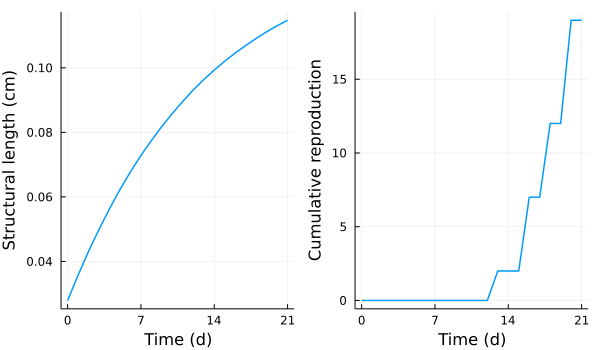

In [20]:
default(legend=false, linewidth=1.5, markerstrokewidth=0) # modify default plotting settings
@df df plot(
    plot(:t_day, :L, xlabel="Time (d)", ylabel="Structural length (cm)"),
    plot(:t_day, :cum_repro, xlabel="Time (d)", ylabel="Cumulative reproduction"), 
    xticks=0:7:21, size=(600,350)
)

The model includes stochasticity and individual variability, 
so we will usually want to simulate multiple replicates. 
This can be done by repeating the process above (starting from `initialize_model`). <br>


`Simulation.jl` also provides the function `life_table`, which automatically does this for 
a given number of replicates and collects the results in a data format 
called `LifeTableDataset`.

In [21]:
ltd = life_table(glb, prm, flp; n_reps=10) # 10 replicates are the default => life_table(glb, prm, flp) produces the same output
println(typeof(ltd))

LifeTableDataset


A `LifeTableDataset` consists of three data frames:

In [22]:
fieldnames(LifeTableDataset)

(:repro, :growth, :survival)

The `repro` data frame also contains all the additional state variables recorded 
by RECORDED_FLEA_ATTRIBS.

In [23]:
first(ltd.repro)

,t_day,unique_id,species_idx,kappa,kappa_EX,q_p_rel,J_X,X_p,f
,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0.0,1,1,0.66472,0.0,1.0,0.227801,218.4,0.952169


The `growth` data frame contains structural length converted to carapace length. <br>
`survival` contains the fraction of surviving individuals over time.

`Figures.jl` provides the `lineplot` and `groupedlineplot!` recipes to 
plot estimates (arithmetic mean by default) and an error band (5th to 95th percentile by default).

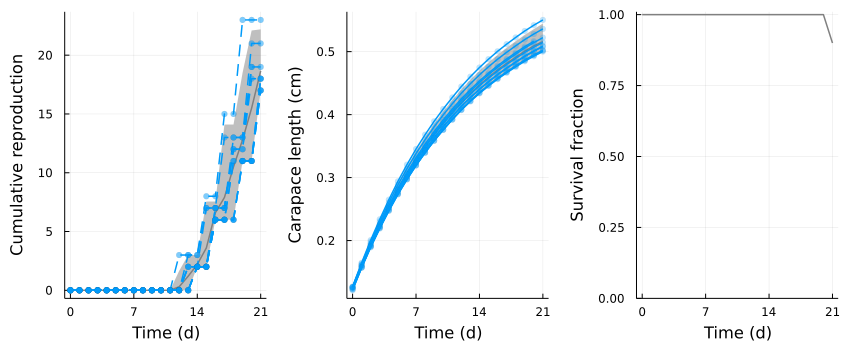

In [24]:
rplt = @df ltd.repro lineplot(:t_day, :cum_repro, color=:gray, fillalpha=.5, ylabel="Cumulative reproduction") # plot mean and 90%ile range
@df ltd.repro groupedlineplot!(:t_day, :cum_repro, :rep, color=1, linestyle=:dash, marker=true, markeralpha=.5) # plot each individual
grplt = @df ltd.growth lineplot(:t_day, :carapace_length, color=:gray, fillalpha=.5, ylabel="Carapace length (cm)")
@df ltd.growth groupedlineplot!(:t_day, :carapace_length, :rep, color=1, marker=true, markeralpha=.25)
svplt = @df ltd.survival lineplot(:t_day, :survival, color=:gray, fillalpha=.5, ylim=(0,1.01), ylabel="Survival fraction")
plot(
    rplt, grplt, svplt, layout=(1,3), size=(850,350), 
    xlabel="Time (d)", xticks=0:7:21, 
    leftmargin=5mm, bottommargin=5mm
)

## Simulating population dynamics

To simulate population dynamics instead of a life-table experiment, 
we only need to pick the corresponding default global parameters.

The `population_renewal` parameter set define simulation of a population experiment 
with two partial medium renewals per week.

  0.254319 seconds (1.62 M allocations: 71.947 MiB, 16.53% gc time)


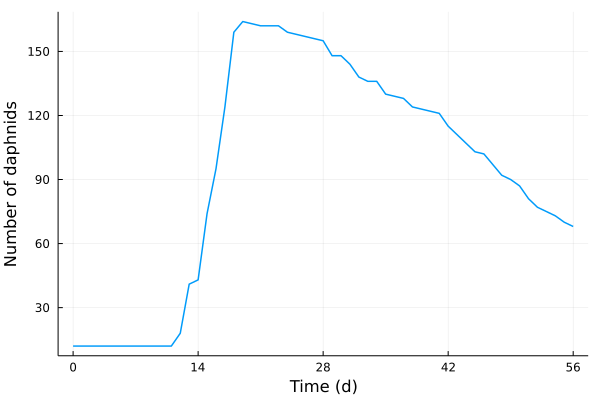

In [65]:
# get the global parameters
glb = deepcopy(default_global.zooplankton.population_renewal) 
# initialize a model object
m = initialize_model(glb, prm, flp) 
# run thje simulation and print the computation time in seconds
@time run!(m) 
# fleas_record_pop is a matrix of population sizes. this line converts the matrix to a data frame
popsizes = DataFrame(m.fleas_record_pop, [:t_day, :species_idx, :N]) 
# plot the population trajectory
@df popsizes plot(:t_day, :N, xlabel="Time (d)", ylabel="Number of daphnids", xticks=0:14:56)

If we increase the volume from 0.5 to 10 L, we get a lower absolute population size.

  0.124044 seconds (878.77 k allocations: 38.218 MiB)


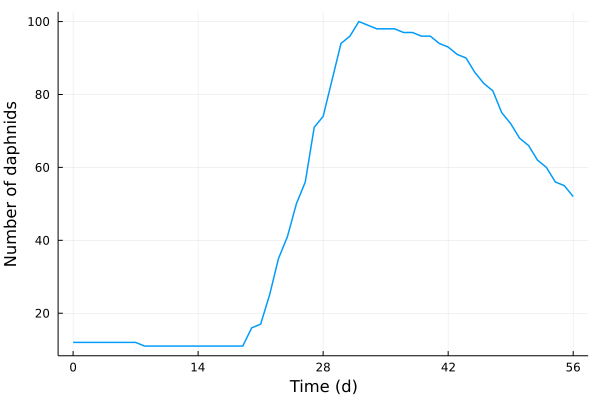

In [67]:
# get the global parameters
glb[:volume] = 10.
# initialize a model object
m = initialize_model(glb, prm, flp) 
# run thje simulation and print the computation time in seconds
@time run!(m) 
# fleas_record_pop is a matrix of population sizes. this line converts the matrix to a data frame
popsizes = DataFrame(m.fleas_record_pop, [:t_day, :species_idx, :N]) 
# plot the population trajectory
@df popsizes plot(:t_day, :N, xlabel="Time (d)", ylabel="Number of daphnids", xticks=0:14:56)

Why? <br>
The reason for this seemingly strange behaviour is that the added food has to be provided as an absolute 
amount, not as a concentration. 
If the volume is increased without a change in the `A_inoculate` parameter, 
food concentration decreases. 
Therefore, ingestion rates decrease (daphnids have to filter more water to get the same amount of food), 
and individuals have overall less energy available.<br><br>
If we increase `A_incoculate` to get the same concentration as before, 
we get an increase in population sizes (and computation times). <br>
As long as we do not consider crowding effects, the volume is mostly relevant for the calculation of ingestion rates. 

  3.457419 seconds (23.68 M allocations: 1.051 GiB, 9.25% gc time)


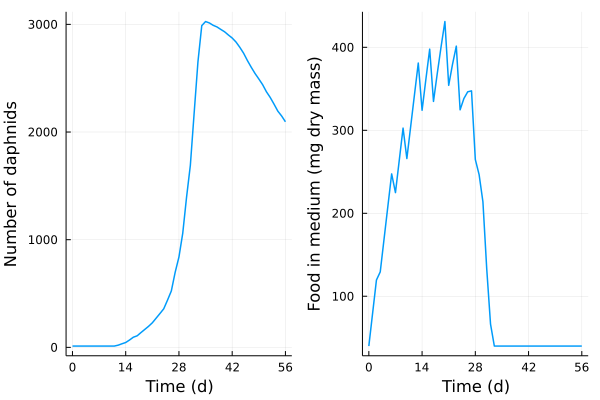

In [80]:
# get the global parameters
glb = copy(default_global.zooplankton.population_renewal) 
glb[:volume] = 10.
glb[:A_inoculate] = [40.]
# initialize a model object
m = initialize_model(glb, prm, flp) 
# run thje simulation and print the computation time in seconds
@time run!(m) 
# fleas_record_pop is a matrix of population sizes. this line converts the matrix to a data frame
popsizes = DataFrame(m.fleas_record_pop, [:t_day, :species_idx, :N]) 
phydat = DataFrame(
    Matrix(hcat(m.phyto_record...)'), 
    [:t_day, :phyto_species_idx, :A, :Q]
    )
# plot the population trajectory
plot(
    (@df popsizes plot(:t_day, :N, xlabel="Time (d)", ylabel="Number of daphnids")),
    (@df phydat plot(:t_day, :A, xlabel="Time (d)", ylabel="Food in medium (mg dry mass)")), 
    xticks=0:14:56
)

## Engaging the TKTD submodel

The TKTD submodel will be refactored in the future for easier use, at which point this section will be updated. <br>
The implementation verification contains some examples of how it is currently used.